In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier



PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20%
ITERATIONS = 100  # Use 100 iterations as per the article


# CMIM ranking of features pre-calculated
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']





class EssentiallyClassifier:
    def __init__(self, file_path, cmim_ranking, percentiles, iterations,name):
        self.name = name
        self.file_path = file_path
        self.cmim_ranking = cmim_ranking
        self.percentiles = percentiles
        self.iterations = iterations
        self.X = None
        self.y = None
        self.optimal_features = None
        self.highest_ppv_1 = 0
        self.final_ppv_scores = []

    def load_discretized_data(self):
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        sorted_indices = np.argsort(probabilities)[::-1]
        sorted_labels = true_labels[sorted_indices]
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100))
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


       
    def find_optimal_features(self):
        X_ranked = self.X[self.cmim_ranking]

        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]
            ppv_1_scores = []

            self.evaluate_model(X_selected, ppv_1_scores)

            mean_ppv_1 = np.mean(ppv_1_scores)
            print(f"Features: {i}, Mean PPV (1%): {mean_ppv_1}")

            if mean_ppv_1 > self.highest_ppv_1:
                self.highest_ppv_1 = mean_ppv_1
                self.optimal_features = i

        print("Highest PPV (1%):", self.highest_ppv_1)
        print("Optimal number of features:", self.optimal_features)

    def evaluate_final_model(self):
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]

        self.evaluate_model(X_optimal, self.final_ppv_scores)

        final_ppv = np.mean(self.final_ppv_scores, axis=0)
        print("Final PPV Percentiles:", final_ppv)
        return final_ppv


    def plot_ppv_results(self, final_ppv):
        fig, ax = plt.subplots(figsize=(10, 6))
        labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        width = 0.2

        ax.bar(np.arange(len(self.percentiles)) - width / 2, final_ppv, width, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + width / 2, random_ppv, width, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()


    def run(self):
        self.load_discretized_data()
        self.find_optimal_features()
        final_ppv = self.evaluate_final_model()
        self.plot_ppv_results(final_ppv)


    def evaluate_model(self, X_selected, ppv_1_scores):
        # To be implemented by subclasses
        pass




class EssentiallyBayesClassifier(EssentiallyClassifier):
    def __init__(self, file_path, cmim_ranking, percentiles, iterations,name):
        super().__init__(file_path, cmim_ranking, percentiles, iterations ,name)

   
    def calcolate_boostrap_iteration(self, X_selected):
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        X_train_minority = X_train[y_train == 1]
        y_train_minority = y_train[y_train == 1]

        X_train_oversampled, y_train_oversampled = resample(
            X_train_minority, y_train_minority,
            replace=True,
            n_samples=np.sum(y_train == 0),
            random_state=42
        )

        # X_train_oversampled = X_train_minority
        # y_train_oversampled = y_train_minority

        X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())

   
    def evaluate_model(self, X_selected, ppv_1_scores):
        for _ in range(self.iterations):
            ppv_iteration = self.calcolate_boostrap_iteration(X_selected)
            ppv_1_scores.append(ppv_iteration[0])
            




class EssentialityRandomForestClassifier(EssentiallyClassifier):
    def __init__(self, file_path, cmim_ranking, percentiles, iterations,name):
        super().__init__(file_path, cmim_ranking, percentiles, iterations,name)

   
    def evaluate_model(self, X_selected, ppv_1_scores):
        
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        X_train_minority = X_train[y_train == 1]
        y_train_minority = y_train[y_train == 1]

        X_train_oversampled, y_train_oversampled = resample(
            X_train_minority, y_train_minority,
            replace=True,
            n_samples=np.sum(y_train == 0),
            random_state=42
        )

        X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = rf_classifier.predict_proba(X_test)[:, 1]

        ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())
        ppv_1_scores.append(ppv_iteration[0])







class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name
        self.classifiers = classifiers
        self.results = [] 

    def run_experiment(self):
        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print("-" * 50)
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
            self.results.append((classifier.cmim_ranking[0], classifier.final_ppv_scores))
    
    def plot_comparative_results(self, percentiles, colors=None):
        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors

        fig, ax = plt.subplots(figsize=(10, 6))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        width = 0.1

        for idx, classifier in enumerate(self.classifiers):
            mean_ppv = np.mean(classifier.final_ppv_scores, axis=0)
            ax.bar(x + idx * width, mean_ppv, width, label=classifier.name, color=colors[idx % len(colors)])

        random_ppv = [np.mean(self.classifiers[0].y)] * len(percentiles)
        ax.bar(x + len(self.classifiers) * width, random_ppv, width, label='Random', color='black')

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + width * (len(self.classifiers) / 2))
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 1)
        ax.legend()
        fig.tight_layout()
        plt.show()




/var/folders/j2/g16nd4ld17z43clcp8bbjqv80000gn/T/ipykernel_38936/2866151883.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
--------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Features: 42, Mean PPV (1%): 0.5382608695652175
Features: 41, Mean PPV (1%): 0.5534782608695652
Features: 40, Mean PPV (1%): 0.5543478260869565
Features: 39, Mean PPV (1%): 0.5460869565217391
Features: 38, Mean PPV (1%): 0.5669565217391306
Features: 37, Mean PPV (1%): 0.5578260869565217
Features: 36, Mean PPV (1%): 0.5795652173913043
Features: 35, Mean PPV (1%): 0.6095652173913043
Features: 34, Mean PPV (1%): 0.5843478260869565
Features: 33, Mean PPV (1%): 0.6060869565217392
Features: 32, Mean PPV (1%): 0.6043478260869566
Features: 31, Mean PPV (1%): 0.6226086956521739
Features: 30, Mean PPV (1%): 0.6556521739

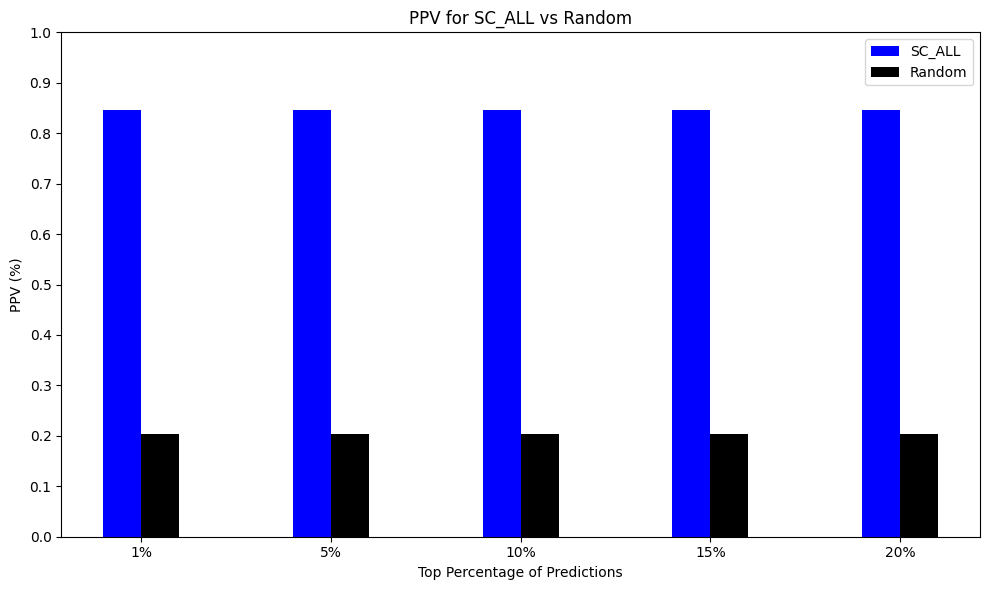

--------------------------------------------------
Running classifier SC_GENPROT
--------------------------------------------------
Features: 16, Mean PPV (1%): 0.7869565217391304
Features: 15, Mean PPV (1%): 0.8073913043478259
Features: 14, Mean PPV (1%): 0.7713043478260869
Features: 13, Mean PPV (1%): 0.7752173913043479
Features: 12, Mean PPV (1%): 0.7943478260869563
Features: 11, Mean PPV (1%): 0.8530434782608696
Features: 10, Mean PPV (1%): 0.8508695652173911
Features: 9, Mean PPV (1%): 0.8504347826086955
Features: 8, Mean PPV (1%): 0.8426086956521738
Features: 7, Mean PPV (1%): 0.8086956521739131
Features: 6, Mean PPV (1%): 0.7960869565217391
Features: 5, Mean PPV (1%): 0.7978260869565217
Features: 4, Mean PPV (1%): 0.7265217391304347
Features: 3, Mean PPV (1%): 0.6565217391304349
Features: 2, Mean PPV (1%): 0.6639130434782607
Features: 1, Mean PPV (1%): 0.5756521739130436
Highest PPV (1%): 0.8530434782608696
Optimal number of features: 11
Final PPV Percentiles: 0.8526086956521738

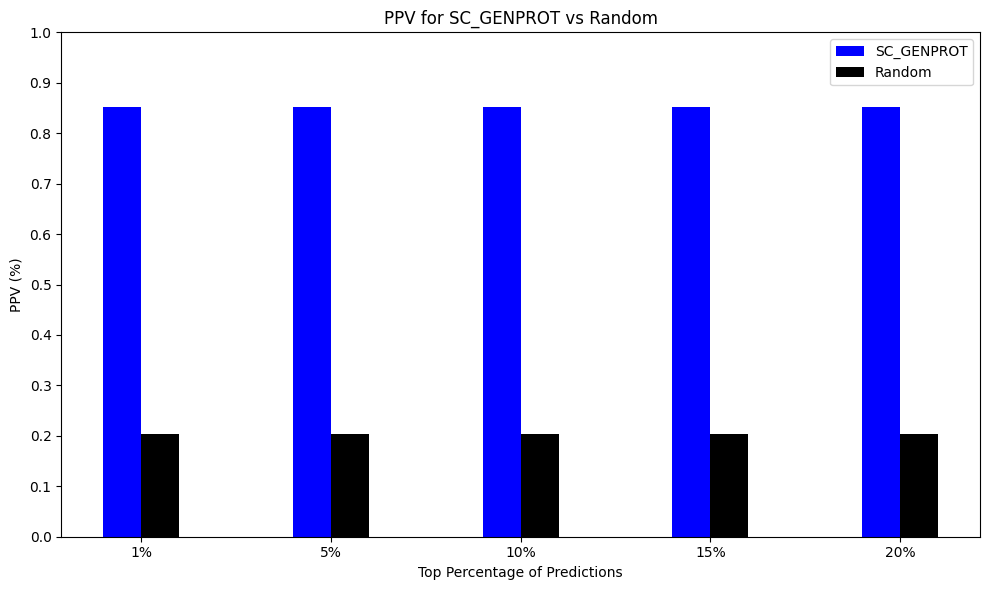

--------------------------------------------------
Running classifier SC_NO_GENPROT
--------------------------------------------------
Features: 15, Mean PPV (1%): 0.6134782608695653
Features: 14, Mean PPV (1%): 0.5717391304347826
Features: 13, Mean PPV (1%): 0.577391304347826
Features: 12, Mean PPV (1%): 0.5465217391304348
Features: 11, Mean PPV (1%): 0.5373913043478261
Features: 10, Mean PPV (1%): 0.5160869565217392
Features: 9, Mean PPV (1%): 0.45217391304347837
Features: 8, Mean PPV (1%): 0.47434782608695647
Features: 7, Mean PPV (1%): 0.5430434782608695
Features: 6, Mean PPV (1%): 0.5182608695652174
Features: 5, Mean PPV (1%): 0.5282608695652175
Features: 4, Mean PPV (1%): 0.5065217391304349
Features: 3, Mean PPV (1%): 0.3869565217391305
Features: 2, Mean PPV (1%): 0.3108695652173913
Features: 1, Mean PPV (1%): 0.24043478260869564
Highest PPV (1%): 0.6134782608695653
Optimal number of features: 15
Final PPV Percentiles: 0.6256521739130435


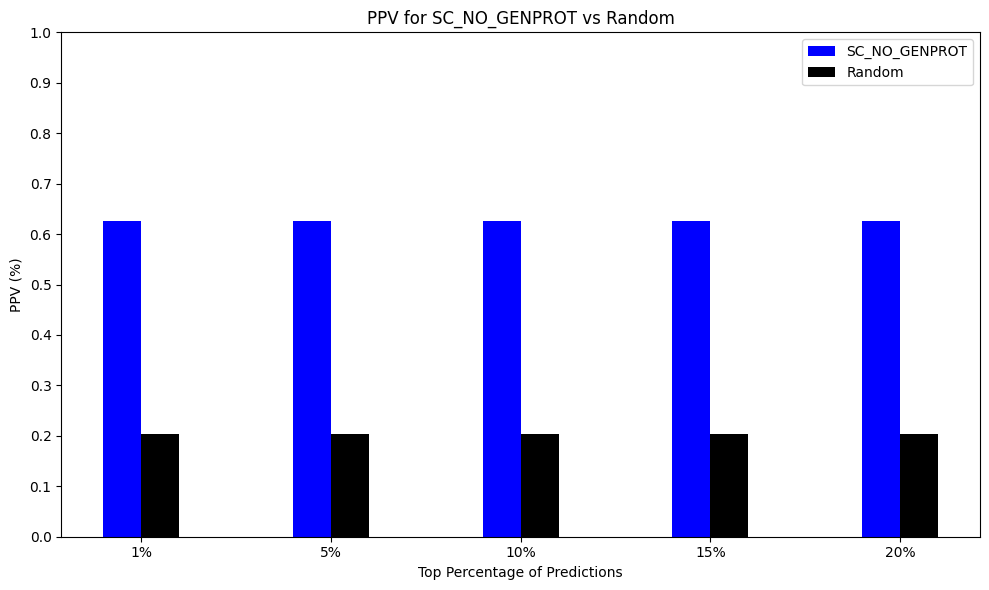

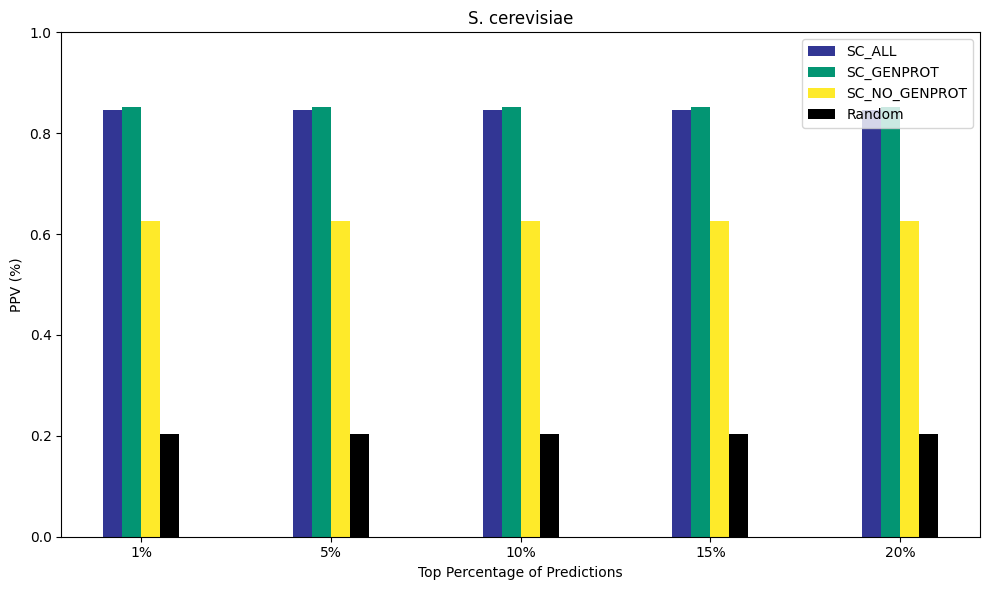

In [2]:


classifier_no_genprot = EssentiallyBayesClassifier('cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, ITERATIONS, name='SC_NO_GENPROT')
classifier_genprot = EssentiallyBayesClassifier('cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, ITERATIONS, name='SC_GENPROT')
classifier_all = EssentiallyBayesClassifier('cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, ITERATIONS, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae", [classifier_all,classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae Random Forest
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
--------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Features: 42, Mean PPV (1%): 0.7391304347826086
Features: 41, Mean PPV (1%): 0.5652173913043478
Features: 40, Mean PPV (1%): 0.6521739130434783
Features: 39, Mean PPV (1%): 0.5652173913043478
Features: 38, Mean PPV (1%): 0.6956521739130435
Features: 37, Mean PPV (1%): 0.5652173913043478
Features: 36, Mean PPV (1%): 0.6086956521739131
Features: 35, Mean PPV (1%): 0.5217391304347826
Features: 34, Mean PPV (1%): 0.6086956521739131
Features: 33, Mean PPV (1%): 0.5217391304347826
Features: 32, Mean PPV (1%): 0.6956521739130435
Features: 31, Mean PPV (1%): 0.4782608695652174
Features: 30, Mean PPV (1%)

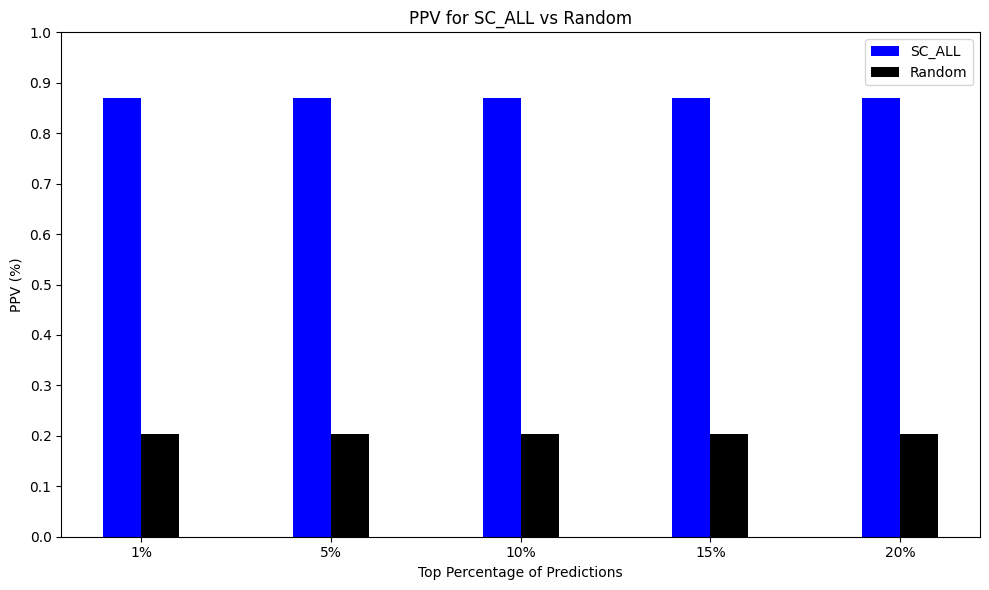

--------------------------------------------------
Running classifier SC_GENPROT
--------------------------------------------------
Features: 16, Mean PPV (1%): 0.5652173913043478
Features: 15, Mean PPV (1%): 0.5217391304347826
Features: 14, Mean PPV (1%): 0.5652173913043478
Features: 13, Mean PPV (1%): 0.6086956521739131
Features: 12, Mean PPV (1%): 0.5217391304347826
Features: 11, Mean PPV (1%): 0.6086956521739131
Features: 10, Mean PPV (1%): 0.6086956521739131
Features: 9, Mean PPV (1%): 0.43478260869565216
Features: 8, Mean PPV (1%): 0.2608695652173913
Features: 7, Mean PPV (1%): 0.5217391304347826
Features: 6, Mean PPV (1%): 0.5217391304347826
Features: 5, Mean PPV (1%): 0.6521739130434783
Features: 4, Mean PPV (1%): 0.7391304347826086
Features: 3, Mean PPV (1%): 0.4782608695652174
Features: 2, Mean PPV (1%): 0.7391304347826086
Features: 1, Mean PPV (1%): 0.5217391304347826
Highest PPV (1%): 0.7391304347826086
Optimal number of features: 4
Final PPV Percentiles: 0.6086956521739131

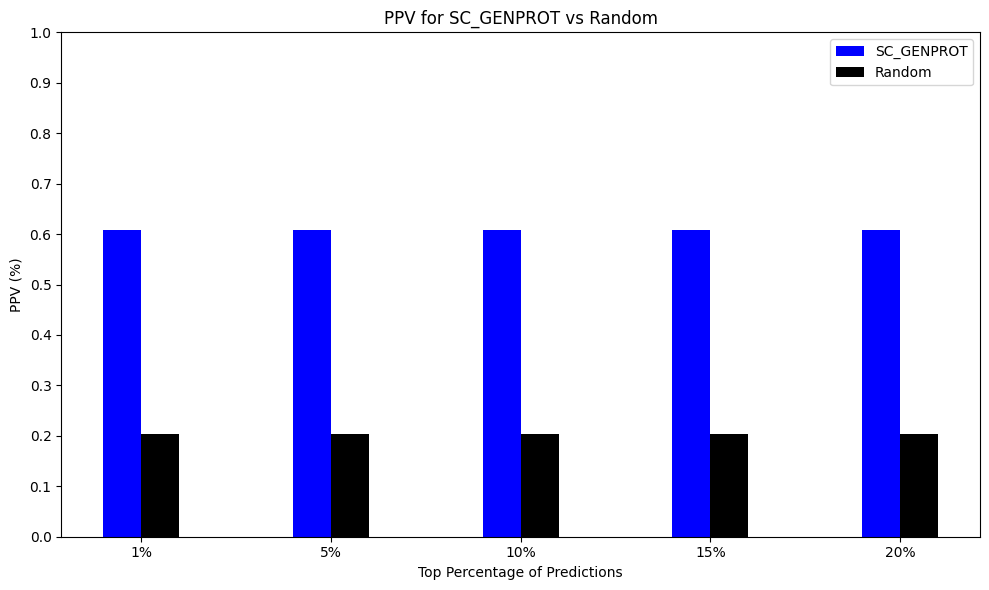

--------------------------------------------------
Running classifier SC_NO_GENPROT
--------------------------------------------------
Features: 15, Mean PPV (1%): 0.391304347826087
Features: 14, Mean PPV (1%): 0.34782608695652173
Features: 13, Mean PPV (1%): 0.2608695652173913
Features: 12, Mean PPV (1%): 0.34782608695652173
Features: 11, Mean PPV (1%): 0.391304347826087
Features: 10, Mean PPV (1%): 0.43478260869565216
Features: 9, Mean PPV (1%): 0.43478260869565216
Features: 8, Mean PPV (1%): 0.17391304347826086
Features: 7, Mean PPV (1%): 0.6086956521739131
Features: 6, Mean PPV (1%): 0.6521739130434783
Features: 5, Mean PPV (1%): 0.4782608695652174
Features: 4, Mean PPV (1%): 0.6086956521739131
Features: 3, Mean PPV (1%): 0.5217391304347826
Features: 2, Mean PPV (1%): 0.391304347826087
Features: 1, Mean PPV (1%): 0.21739130434782608
Highest PPV (1%): 0.6521739130434783
Optimal number of features: 6
Final PPV Percentiles: 0.5217391304347826


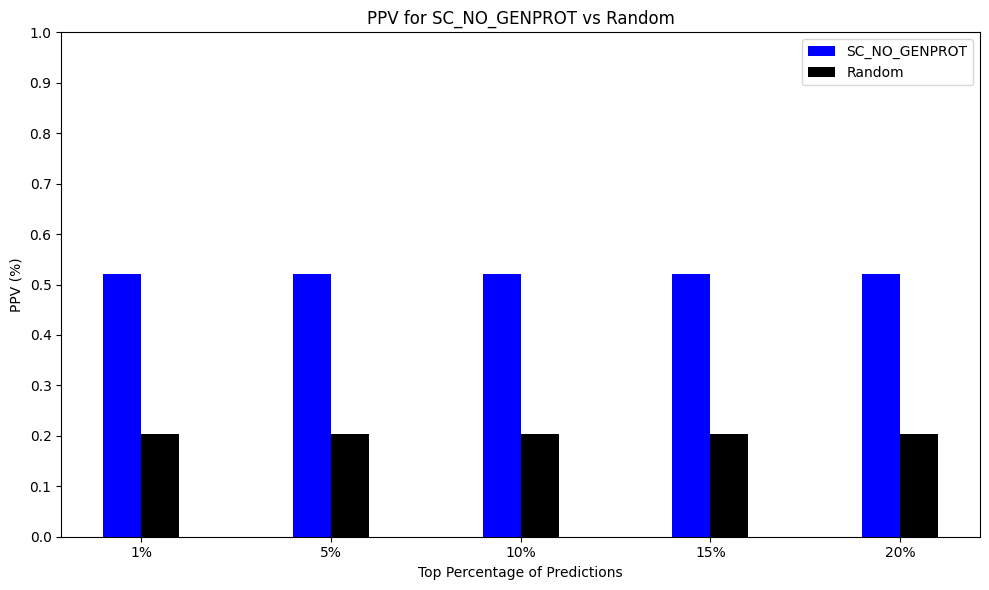

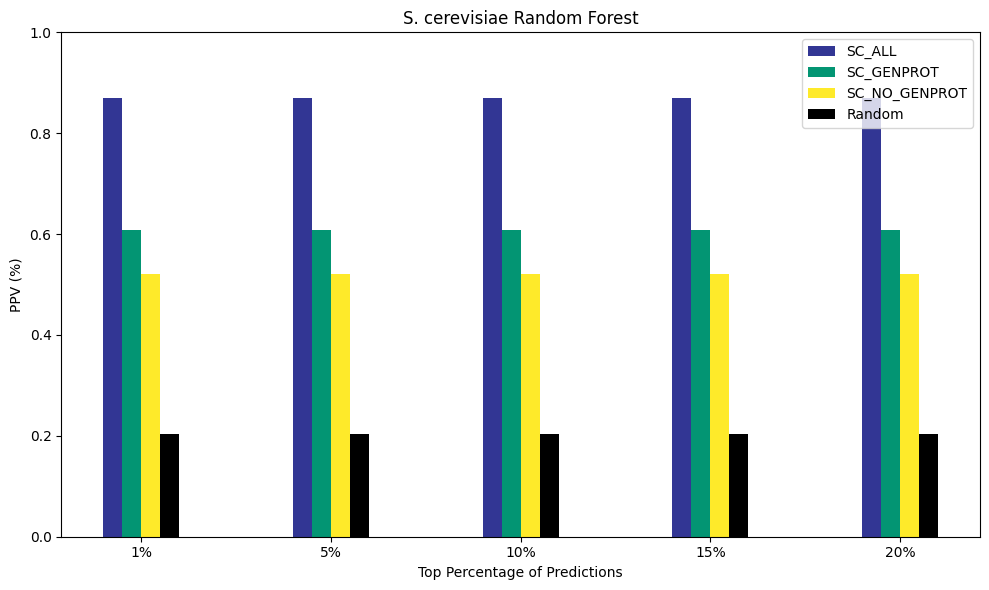

In [3]:


classifier_no_genprot = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, ITERATIONS, name='SC_NO_GENPROT')
classifier_genprot = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, ITERATIONS, name='SC_GENPROT')
classifier_all = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, ITERATIONS, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae Random Forest", [classifier_all,classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])

